In [1]:
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import pandas_market_calendars as mcal
import constants as cs
import model
import utils

[*********************100%%**********************]  2 of 2 completed


,LONN.SW,SIKA.SW
Date,,
2023-08-08,491.200012,267.5


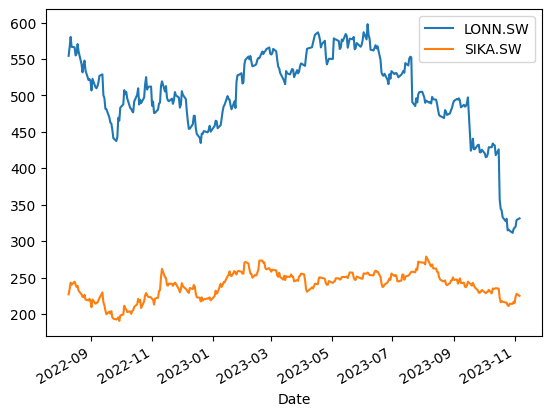

In [2]:
historical_start_date = '2022-08-09'
# Define the ticker list
ticker_list = ['LONN.SW', 'SIKA.SW']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
data.plot()
display(data[data.index == pd.to_datetime('2023-08-08')])

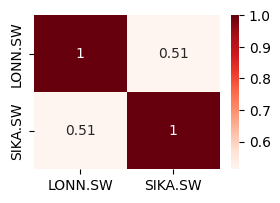

In [3]:
plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [4]:
data

,LONN.SW,SIKA.SW
Date,,
2022-08-09,554.423462,227.111465
2022-08-10,566.350830,234.319778
2022-08-11,580.464905,243.206757
2022-08-12,566.748413,240.343170
2022-08-15,566.152039,244.490433
...,...,...
2023-10-31,316.799988,216.899994
2023-11-01,318.600006,215.199997
2023-11-02,320.000000,223.800003


In [5]:
# Check all attributes of the constants module
dir(cs)


['BARRIER',
 'CONVERSION_RATIOS',
 'COUPON_PAYMENT_DATES',
 'COUPON_PAYOUT',
 'COUPON_RATE',
 'DENOMINATION',
 'EARLY_REDEMPTION_DATES',
 'EARLY_REDEMPTION_LEVEL',
 'EARLY_REDEMPTION_LEVELS',
 'EARLY_REDEMPTION_OBSERVATION_DATES',
 'EARLY_REDEMPTION_OBSERVATION_FREQUENCY',
 'FINAL_FIXING_DATE',
 'FIRST_PRODUCT_PRICE_EST_DATE',
 'HISTORICAL_START_DATE',
 'INITIAL_FIXING_DATE',
 'ISSUE_PRICE_PERCENTAGE',
 'PAYMENT_DATE',
 'REDEMPTION_DATE',
 'SIX_HOLIDAY_DATES',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'pd']

In [6]:
print(cs.SIX_HOLIDAY_DATES)

[Timestamp('2023-01-02 00:00:00'), Timestamp('2023-04-07 00:00:00'), Timestamp('2023-04-10 00:00:00'), Timestamp('2023-05-01 00:00:00'), Timestamp('2023-05-18 00:00:00'), Timestamp('2023-05-29 00:00:00'), Timestamp('2023-08-01 00:00:00'), Timestamp('2023-12-25 00:00:00'), Timestamp('2023-12-26 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2024-01-02 00:00:00'), Timestamp('2024-03-29 00:00:00'), Timestamp('2024-04-01 00:00:00'), Timestamp('2024-05-01 00:00:00'), Timestamp('2024-05-09 00:00:00'), Timestamp('2024-05-20 00:00:00'), Timestamp('2024-08-01 00:00:00'), Timestamp('2024-12-24 00:00:00'), Timestamp('2024-12-25 00:00:00'), Timestamp('2024-12-26 00:00:00'), Timestamp('2024-12-31 00:00:00')]


In [7]:

params = {
    'data': data,
    'ticker_list': ['LONN.SW', 'SIKA.SW']
}
test_model = model.PricingModel(params = params)
test_model.data
test_model.multidimensional_gbm(sim_start_date = pd.Timestamp('2023-08-09'), hist_window = 252, sim_window = 63)

Covariance matrix is:
 [[0.00039993 0.00023545]
 [0.00023545 0.00043437]]

The shape is (2, 2)

Correlation between the two var is 0.5648985809380564
The matrix after Cholesky decomposition is:
 [[0.01999821 0.        ]
 [0.0117734  0.01719768]]

The multiplication of L and L transpose is:
 [[0.00039993 0.00023545]
 [0.00023545 0.00043437]]

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039992845055450155 -0.008593369489947334
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.0004343732296462165 -0.0228569699743487
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039992845055450155 -0.01145624838633269
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.0004343732296462165 -0.008445822708007282
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039992845055450155 0.004222793477471142
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.

,LONN.SW,SIKA.SW
0,487.030468,261.473040
1,481.515820,259.291766
2,483.586658,260.468618
3,479.590094,261.292454
4,474.750591,255.976694
...,...,...
58,473.741474,213.528310
59,468.672801,208.958726
60,487.994097,216.159616
61,483.975882,215.445503


In [16]:
# Takes the start and end dates to create a trading calendar for SIX
# Returns a df with all the dates of trading days as index
def create_six_trading_dates(start_date, end_date):
    six_calendar = mcal.get_calendar('SIX')
    print(f"Holidays in the calendar up to 2200: {six_calendar.holidays().holidays[-10:]}")
    six_trading_days = six_calendar.valid_days(start_date, end_date)

    six_trading_days_df = pd.DataFrame(index = six_trading_days)
    
    # Name the index "Dates"
    six_trading_days_df.index.name = 'Dates'
    return six_trading_days_df

trading_df = create_six_trading_dates('2023-01-01', '2023-12-31')
utils.remove_SIX_holidays(data = trading_df)

Holidays in the calendar up to 2200: (numpy.datetime64('2200-04-04'), numpy.datetime64('2200-04-07'), numpy.datetime64('2200-05-01'), numpy.datetime64('2200-05-15'), numpy.datetime64('2200-05-26'), numpy.datetime64('2200-08-01'), numpy.datetime64('2200-12-24'), numpy.datetime64('2200-12-25'), numpy.datetime64('2200-12-26'), numpy.datetime64('2200-12-31'))


""
Dates
2023-01-03 00:00:00+00:00
2023-01-04 00:00:00+00:00
2023-01-05 00:00:00+00:00
2023-01-06 00:00:00+00:00
2023-01-09 00:00:00+00:00
...
2023-12-20 00:00:00+00:00
2023-12-21 00:00:00+00:00
2023-12-22 00:00:00+00:00


The dates to drop are: []


""
Dates
2023-01-03 00:00:00+00:00
2023-01-04 00:00:00+00:00
2023-01-05 00:00:00+00:00
2023-01-06 00:00:00+00:00
2023-01-09 00:00:00+00:00
...
2023-12-20 00:00:00+00:00
2023-12-21 00:00:00+00:00
2023-12-22 00:00:00+00:00


In [9]:
def get_last_bus_date(input_date):
    pass

,LONN.SW,SIKA.SW
Date,,
2022-08-11,580.464905,243.206757
2022-08-12,566.748413,240.343170
2022-08-15,566.152039,244.490433
2022-08-16,555.019897,240.343170
2022-08-17,557.206543,237.380844
...,...,...
2023-08-03,490.000000,268.200012
2023-08-04,493.000000,279.000000
2023-08-07,490.200012,271.100006


Covariance matrix is:
 [[0.00039744 0.00023186]
 [0.00023186 0.00042921]]

The shape is (2, 2)

Correlation between the two var is 0.561365644897236
The matrix after Cholesky decomposition is:
 [[0.01993589 0.        ]
 [0.01163006 0.01714509]]

The multiplication of L and L transpose is:
 [[0.00039744 0.00023186]
 [0.00023186 0.00042921]]

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039743977849204543 -0.04601701049226781
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00042921257743639573 -0.07122611147884796
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039743977849204543 -0.011727915357877466
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00042921257743639573 0.00860064795031343
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0175 0.00039743977849204543 0.06069307341627072
<class 'float'> <class 'numpy.float64'> <class 'numpy.float64'>
0.0

,LONN.SW,SIKA.SW
0,467.039639,247.264181
1,461.625924,249.417092
2,490.544797,258.491839
3,507.643763,258.883926
4,505.569568,263.971808
...,...,...
58,524.377617,273.418242
59,507.638306,265.732571
60,500.445243,260.931971
61,494.896257,259.097884


63 63


,LONN.SW,SIKA.SW,simulated_LONN.SW,simulated_SIKA.SW
Date,,,,
2023-08-10,498.100006,268.299988,467.039639,247.264181
2023-08-11,494.899994,262.799988,461.625924,249.417092
2023-08-14,494.200012,262.500000,490.544797,258.491839
2023-08-15,487.899994,258.100006,507.643763,258.883926
2023-08-16,479.799988,257.399994,505.569568,263.971808
...,...,...,...,...
2023-10-31,316.799988,216.899994,524.377617,273.418242
2023-11-01,318.600006,215.199997,507.638306,265.732571
2023-11-02,320.000000,223.800003,500.445243,260.931971


/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/op

<Axes: xlabel='Date'>

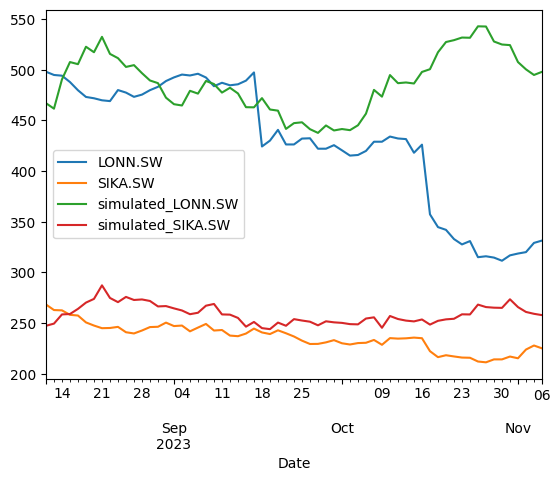

In [10]:
# Still runnable in this block
sim_start_date = cs.FIRST_PRODUCT_PRICE_EST_DATE + pd.Timedelta(days = 1) # TODO: Need to consider non-business days
last_avai_price_date = sim_start_date - pd.Timedelta(days = 1)

S_t = [data.loc[last_avai_price_date, ticker] for ticker in ticker_list] # Stock price of the 0th day of simulation
time_steps_per_year = 252
hist_window = time_steps_per_year
dt = 1/time_steps_per_year
r = 1.750/100 
# TODO: from the simulation date to the final fixing date is roughly 8 months, so I choose a 6-month bond yield that is closest to the time horizon (8 months)
# And then find the closest date to the simulation date (around August 10)
T = 63 # Number of simulation days (#TODO: To be changed later)
num_ticker = len(ticker_list) # Number of stocks

# TODO: Ask if can use historical?
# Use historical data to estimate covariance matrix. (up to last_avai_price date?)

# TODO: Save into a df with dates if needed

hist_data = data[data.index < sim_start_date].tail(hist_window)
display(hist_data)

log_returns_list = []
for ticker in ticker_list:
    # display(data[ticker], data[ticker].shift(1))
    log_returns = np.log(hist_data[ticker] / hist_data[ticker].shift(1)) # np.log is natural log, (P_i/P_i-1)
    log_returns.dropna(inplace = True) # A series
    log_returns_list.append(log_returns)
    # print(type(log_returns))

# print(log_returns_list)
# print(np.shape(log_returns_list))


# print(f"np.array {np.array(log_returns_list)}")
cov_matrix = np.cov(np.array(log_returns_list))
print(f"Covariance matrix is:\n {cov_matrix}\n")
print(f"The shape is {np.shape(cov_matrix)}\n")

print(f"Correlation between the two var is {cov_matrix[0][1] / (cov_matrix[0][0] * cov_matrix[1][1]) ** 0.5}") # Correct

L = np.linalg.cholesky(cov_matrix)
print(f"The matrix after Cholesky decomposition is:\n {L}\n")

print(f"The multiplication of L and L transpose is:\n {np.dot(L, L.T)}\n") 

sim_data = pd.DataFrame(np.zeros((T, num_ticker)), columns = [ticker_list])

# display(sim_data)
# TODO: N number of simulations
 
# print(sim_data.loc[0, "LONN.SW"])
for t in range(T): # TODO: change to num of days to sim (date range or sth)
    Z = np.random.normal(0, 1, num_ticker) # returns a scalar if size is not specified
    for i in range(num_ticker): # day need to go first, 
        if t == 0: prev_price = S_t[i]
        else: prev_price = sim_data.loc[t - 1, ticker_list[i]].item()
        LZ = np.dot(L, Z)

        print(type(prev_price), type(cov_matrix[i][i]), type(LZ[i]))
        print(r, cov_matrix[i][i], LZ[i])
        sim_data.loc[t, ticker_list[i]] = prev_price * np.exp(r * dt - 0.5 * cov_matrix[i][i] * dt + LZ[i]) # The cov matrix and L need to be computed on the fly

display(sim_data)

sim_data.columns = ["simulated_" + ticker for ticker in ticker_list]

# A dataframe with both validation data and simulated data

val_df = data[data.index >= sim_start_date]
print(len(val_df), len(sim_data))
# Ensure sim_data has the same index as val_df
sim_data.index = val_df.index

# Concatenate val_df and sim_data along columns
val_df_with_sim = pd.concat([val_df, sim_data], axis=1)
display(val_df_with_sim)

# for t in time step from simulation start until end date
# TODO: get market calendar date times: minus weekdays, holidays

val_df_with_sim.plot()
